In [1]:
# !pip install textacy

In [1]:
import pandas as pd
import numpy as np
import os
import re
import string
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# !pip uninstall certifi -y
# !pip install --no-cache-dir certifi==2025.7.14

from textacy import preprocessing as tprep
from tqdm import tqdm
tqdm.pandas()


pd.options.display.max_rows = 15


In [2]:
# Article Dataframe
article_df = pd.read_csv('/Users/amalkurian/Desktop/Dissertation/Bias Detection/Data/matching_articles03.csv')
print(f'List all the columns{list(article_df.columns)}')

List all the columns['title', 'author', 'source', 'content', 'topic', 'url', 'keywords', 'query', 'cleaned_content', 'entities', 'article_id', 'entities_Group', 'labels_Group', 'Key_Phrases', 'Actions', 'Load_Date', 'Language', 'Person', 'matching_events', 'character_count', 'word_count', 'processed_text', 'processed_tokens_split', 'num_tokens', 'actor_entities', 'geo_entities', 'story_chain', 'match_score_faiss', 'temporal_scores', 'temporal_exp_score', 'temporal_log_score', 'match_score_Title', 'event_similarity_id_Title', 'match_label_x', 'match_label_y', 'match_label']


In [3]:
# Events Datafrane
events_df = pd.read_csv('/Users/amalkurian/Desktop/Dissertation/Bias Detection/diffbot-export-tigray-war.csv')
print(f'List all the columns{list(events_df.columns)}')

List all the columns['title', 'date_str', 'author', 'icon', 'siteName', 'tags_label', 'text', 'sentiment', 'pageUrl', 'quotes_quote']


In [4]:
import hashlib

def generate_event_id(row):
    raw_String = f"{row['date_str']}_{row['title']}_{row['author']}"
    return hashlib.sha256(raw_String.encode('utf-8')).hexdigest()


events_df['event_id'] = events_df.progress_apply(generate_event_id, axis=1)



100%|██████████| 2510/2510 [00:00<00:00, 8624.70it/s]


In [ ]:
# def clean_article(text):
#      parts = re.split(r"\bBody\b", text, flags=re.IGNORECASE)
#      return parts[-1].strip() if len(parts) > 1 else parts[0].strip()
# extract text after the word "Body" from the Raw Text

# article_df['cleaned_content'] = article_df['content'].progress_apply(lambda x: clean_article(x) if isinstance(x, str) else x)

article_df['cleaned_content'].head()

0    Link to Story\n\nIn October, Ethiopian Prime M...
1    Eritrea acknowledged its troops are taking par...
2    Rebels in Ethiopia's war-hit Tigray have carri...
3    Ethiopia declared a six-month state of emergen...
4    ruled in March that all voting would need to b...
Name: cleaned_content, dtype: object

In [86]:
# Article Dataframe: Extracting Entities using Spacy
# Event Dataframe: Extracting Entities using Spacy
import spacy
from tqdm.auto import tqdm

nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text) # gets the entities in the text
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities


article_df['entities'] = article_df['cleaned_content'].progress_apply(lambda x: extract_entities(x) if isinstance(x, str) else [])


100%|██████████| 3322/3322 [09:30<00:00,  5.82it/s] 


In [16]:
# Events Dataframe: Extracting Entities using Spacy
# Character count has to be less than 1 million to avoid memory issues

def safe_extract(text):
    if isinstance(text, str) and len(text) < 1_000_000:
        return extract_entities(text)
    return []


events_df['entities'] = events_df['text'].progress_apply(safe_extract)



100%|██████████| 2510/2510 [11:33<00:00,  3.62it/s]


In [17]:
# Explode the entities For Events Dataframe
events_entities_long = events_df[['event_id', 'entities']].explode('entities')

# # Extract entity text and label
events_entities_long[['entity_text', 'label']] = pd.DataFrame(
    events_entities_long['entities'].tolist(), index=events_entities_long.index
)


events_entities_long.head()

,event_id,entities,entity_text,label
0,10611e1253fa30334825388305170d3196c55d2b1adb91...,"(Ethiopia, GPE)",Ethiopia,GPE
0,10611e1253fa30334825388305170d3196c55d2b1adb91...,"(Eritrea, GPE)",Eritrea,GPE
0,10611e1253fa30334825388305170d3196c55d2b1adb91...,"(two-year-long, DATE)",two-year-long,DATE
0,10611e1253fa30334825388305170d3196c55d2b1adb91...,"(Ethiopia, GPE)",Ethiopia,GPE
0,10611e1253fa30334825388305170d3196c55d2b1adb91...,"(Ethiopia, GPE)",Ethiopia,GPE


In [ ]:
# Exploding the entities for article_df dataframe
article_df['article_id'] = article_df.index

# Explode the entities
entities_long = article_df[['article_id', 'entities']].explode('entities')

# # Extract entity text and label
entities_long[['entity_text', 'label']] = pd.DataFrame(
    entities_long['entities'].tolist(), index=entities_long.index
)




In [90]:
article_df['entities_Group']

0       ['October', 'Ethiopian', 'Abiy Ahmed', 'Tigray...
1       ['Eritrea', 'Ethiopia', 'Northern Tigray', 'fi...
2       ['Ethiopia', 'Afar', 'Sunday', 'eight-month', ...
3       ['Ethiopia', 'six-month', 'Tuesday', 'Tigray',...
4       ['March', 'early October', 'Tigrayan', 'Septem...
                              ...                        
3317    ['JOHANNESBURG', 'first', 'Ethiopian', 'Tigray...
3318    ['U.S.', 'Chris Van Hollen', 'fifteen', 'Senat...
3319    ['Tigrayan', 'Monday', 'Ethiopia', 'Amhara', '...
3320    ['Ethiopia', 'Human Rights Watch', 'Sunday', '...
3321    ['Ethiopia', 'Tigray', 'Mekele', '19 months', ...
Name: entities_Group, Length: 3322, dtype: object

In [ ]:
# Article Df extract keywords
grouped_entities = (entities_long
        .groupby('article_id')
        .agg({
            'entity_text': lambda x: list(x),
            'label': lambda x: list(x)
        })
        .rename(columns={
            'entity_text': 'entities_Group', 'label': 'labels_Group'})
        )

article_df = article_df.merge(grouped_entities, on='article_id', how='left')


def extract_keywords(text):
    doc = nlp(text)
    keyphrases = set()
    for chunk in doc.noun_chunks:
        if len(chunk.text.split()) > 1:  # Only consider multi-word phrases
            keyphrases.add(chunk.text.lower())

    verbs = {token.lemma_ for token in doc if token.pos_ == 'VERB' and token.lemma_ not in stopwords.words('english')}
    return list(keyphrases), list(verbs)

article_df[['Key_Phrases', 'Actions']] = article_df['cleaned_content'].progress_apply(lambda x: pd.Series(extract_keywords(x) if isinstance(x, str) else ([], [])))



In [27]:
# Events KeyPhrases
# Exploding the entities in the tuple form into different columns
import spacy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000  # Set this higher to avoid E088 error

grouped_entities = (events_entities_long
        .groupby('event_id')
        .agg({
            'entity_text': lambda x: list(x),
            'label': lambda x: list(x)
        })
        .rename(columns={
            'entity_text': 'entities_Group', 'label': 'labels_Group'})
        )

events_df = events_df.merge(grouped_entities, on='event_id', how='left')

# Keywords Extraction
events_df[['Key_Phrases', 'Actions']] = events_df['text'].progress_apply(lambda x: pd.Series(extract_keywords(x) if isinstance(x, str) else ([], [])))


100%|██████████| 2510/2510 [14:12<00:00,  2.94it/s] 


In [ ]:
def extract_metadata(text):
    # Load - Date
    load_Date = re.search(r'Load-Date:\s*([A-Za-z]+\s+\d{1,2},\s+\d{4})', text)
    load_Date = load_Date.group(1).strip() if load_Date else None
    # Language
    language = re.search(r'Language:\s*([a-zA-Z]+)', text)
    language = language.group(1).strip() if language else None
    # Person
    person_match = re.search(r'Person:\s*([a-zA-Z\s]+)',text)
    person = person_match.group(1).strip() if person_match else None
    return load_Date, language, person

article_df[['Load_Date', 'Language', 'Person']] = article_df['cleaned_content'].progress_apply(
    lambda x: pd.Series(extract_metadata(x) if isinstance(x, str) else (None, None, None)))

article_df['Load_Date'] = pd.to_datetime(article_df['Load_Date'])

100%|██████████| 3322/3322 [00:01<00:00, 3109.28it/s]


In [29]:
# Format the date extracted into DateTime format %Y-%m-%d

events_df['date_str'] = (
    events_df['date_str']
    .str.replace(r'^d','',regex=True)
)

events_df['date_str'] = events_df['date_str'].str.split('T').str[0] # str is an accessor for string operations on Series
events_df['date_str'] = pd.to_datetime(events_df['date_str'], format='%Y-%m-%d', errors='coerce')
events_df['date_str'].head()

0   2022-10-10
1   2022-10-16
2   2022-10-12
3   2022-10-13
4   2022-12-14
Name: date_str, dtype: datetime64[ns]

In [23]:
# # Format the date into matching for events

article_df['Load_Date'] = pd.to_datetime(article_df['Load_Date'], format='%Y-%m-%d')
article_df['Load_Date']


0      2021-11-05
1      2021-04-18
2      2021-07-18
3      2021-11-03
4      2020-11-04
          ...    
3317   2022-10-25
3318   2020-11-20
3319   2021-12-22
3320   2020-11-22
3321   2024-06-05
Name: Load_Date, Length: 3322, dtype: datetime64[ns]

In [33]:
# Filter events for each article based on the date range


from datetime import timedelta

delta = timedelta(days=7)

def filter_events_for_article(Article_date):
    
    lower = Article_date - timedelta(days=27)
    upper = Article_date + timedelta(days=7) 
    filtered = events_df[events_df['date_str'].between(lower, upper)] # it is a DataFrame
    return filtered['event_id'].tolist()


article_df['Load_Date'] = pd.to_datetime(article_df['Load_Date'])
article_df['Load_Date'].head()

article_df['matching_events'] = article_df['Load_Date'].progress_apply(filter_events_for_article)


  0%|          | 0/3322 [00:00<?, ?it/s]

100%|██████████| 3322/3322 [00:05<00:00, 580.08it/s]


In [19]:
missing_values = article_df['content'].isnull().sum()
print(f'Missing_values: {missing_values}')

Missing_values: 0


In [20]:
article_df['character_count'] = article_df['content'].progress_apply(lambda x: len(x))
article_df['word_count'] = article_df['content'].progress_apply(lambda x: len(x.split()))

100%|██████████| 3322/3322 [00:00<00:00, 11774.59it/s]


In [21]:
categorical_columns = article_df.select_dtypes(include = ['object', 'string']).columns
article_df[categorical_columns].describe().T

,count,unique,top,freq
title,3322,3322,can ethiopia survive? what might happen if abi...,1
author,803,312,States News Service,76
source,3322,233,BBC Monitoring: International Reports,583
content,3322,3317,Ethiopia says reports of air strikes on Tigray...,2
url,3322,3319,https://advance.lexis.com/document/teaserdocum...,2
...,...,...,...,...
Key_Phrases,3322,3306,"[a ceasefire request, getachew reda, nine divi...",3
Actions,3322,3243,"[accuse, Blinken, reject, call, describe, kill...",3
Language,3322,6,ENGLISH,2971
Person,2199,99,ABIY AHMED,1687


In [22]:
numerical_columns = article_df.select_dtypes(include = ['int64', 'float64']).columns
article_df[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
doc_id,3322.0,1660.500000,959.123124,0.0,830.25,1660.5,2490.75,3321.0
topic,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bias,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bias_labels,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
query,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
article_id,3322.0,1660.500000,959.123124,0.0,830.25,1660.5,2490.75,3321.0
character_count,3322.0,4823.025286,5616.219330,938.0,2733.00,3785.5,5261.25,178819.0
word_count,3322.0,726.027092,903.962469,126.0,398.00,560.0,795.00,29013.0


In [23]:
def get_word_count(text):
    if isinstance(text, str):
        return len(text.split())
    else:
        return 0
    
def lowercase_text(text):
    if isinstance(text, str):
        return text.lower()
    else:
        return text

def normalize_text(text):
    if isinstance(text, str):
        text = tprep.normalize.hyphenated_words(text)
        text = tprep.normalize.unicode(text)
        text = tprep.normalize.quotes(text)
        text = tprep.normalize.emails(text)
        text = tprep.normalize.urls(text) # removes URLs or replaces them with a placeholder
        # text = tprep.normalize.remove_punctuation(text)
        text = tprep.normalize.remove_accents(text)           
    else:
        return text
    
# For extracting the domain from URLs
# rex_url_c = rex.compile(r'http[s]?:[\/]+[\S]*[\s]')
# urlparse(url).netloc.replace('www.', '') can be used to extract the domain from a URL. Netloc gives the name of the website, and replacing 'www.' removes the subdomain if present.    
def remove_stopwords(text):
    if isinstance(text, str):
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        return ' '.join(word for word in tokens if word.lower() not in stop_words)
    else:
        return text    


def remove_emojis(text): # shorter
    if isinstance(text, str):
        return emoji.replace_emoji(text, replace='')
    else:
        return text
    
    # if isinstance(text, str): # # longer version
    #     # This regex pattern matches a wide range of emojis and symbols
    #     # It includes emoticons, symbols, flags, and various pictographs.
    #     # Note: This pattern may not cover all emojis, especially newer ones.
    #     # You can adjust the ranges based on your specific needs.
    #     emoji_pattern = re.compile("["
    #                                 u"\U0001F600-\U0001F64F"  # Emoticons
    #                                 u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
    #                                 u"\U0001F680-\U0001F6FF"  # Transport & map symbols
    #                                 u"\U0001F1E0-\U0001F1FF"  # Flags
    #                                 u"\U00002500-\U00002BEF"  # Chinese/Japanese/Korean symbols
    #                                 u"\U00002700-\U000027BF"  # Dingbats
    #                                 u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    #                                 u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    #                                 u"\U0001F000-\U0001F02F"  # Mahjong tiles
    #                                 "]+", flags=re.UNICODE)
    #     return emoji_pattern.sub(r'', text)
    # else:
    #     return text
     
punct_set = set(string.punctuation + '“”‘’')  # includes curly quotes and apostrophes
#next(iter(step(text, args={'punct_set': punct_set})),'Done')  # to see the first element of the set

def remove_punctuations(text, punct_set=punct_set):
    if isinstance(text, str):
        return ''.join(char for char in text if char not in punct_set)
    else:
        return text

def rex_replace(text):
    if isinstance(text, str):
        # Replace multiple spaces with a single space    
        Replace_text = ['&nbsp;', '-', '\n', '\u2063', '\u2066', '\u2069', '\u200b', '\u200d',
        '(click to view)', 'a post shared by', 'app users click here',
        'app users: click here', 'app users, click here:',
        'click here.', 'click here for more cartoons',
        'click here for more', 'click here for more sports coverage on foxnews.com',
        'click here for other fox news digital adoptable pets stories',
        'click here for the fox news app', 'click here for the latest fox news reporting',
        'click here for topline and cross tabs conducted',
        'click here to hear more', 'click here to ge the fox news app',
        'click here to get the fox news app', 'click here to get the opinion newsletter',
        'click here to learn more', 'click here to read more',
        'click here to sign up for our health newsletter',
        'click here to sign up for our lifestyle newsletter',
        'click here to sign up for our opinion newsletter',
        'click here to sign up for the entertainment newsletter',
        'click here to subscribe and get your first year of fox nation free of charge',
        'click here to view',
        "click to get kurt's cyberguy newsletter with quick tips, tech reviews, security alerts and easy how to's to make you smarter",
        "click to get kurt's cyberguy newsletter with security alerts, quick tips, tech reviews, security and easy how to's to make you smarter",
        "click to get kurt's free cyberguy newsletter with quick tips, tech reviews, security alerts and easy how to's to make you smarter",
        "click to get kurt's free cyberguy newsletter with security alerts, quick tips, tech reviews, and easy how to's to make you smarter",
        'click to get the fox news app', 'fox news digital', 'request for comment',
        "please let us know if you're having issues with commenting",
        'view this post on instagram',]
        for pattern in Replace_text:
            text = re.sub(pattern, ' ', text, flags=re.IGNORECASE)
        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text)
    else:
        return text

In [ ]:
def prepare_text(text, pipeline = None):
    text = str(text)
    for transformer in pipeline: # first list
        trans = list(transformer.keys())[0] # item in the first list
        tokens = trans(text)
        return tokens

In [ ]:

transformer01 = [
    {lowercase_text: None},
    {normalize_text: None},
    {remove_punctuations: None},
    {remove_emojis: None},
    {rex_replace: None},
    {remove_stopwords: None},
    ]

article_df['processed_text'] = article_df['cleaned_content'].progress_apply(prepare_text, pipeline = transformer01)
article_df['processed_tokens_split'] = article_df['processed_text'].progress_apply(lambda x: x.split())
article_df['num_tokens'] = article_df['processed_text'].progress_apply(lambda x: len(x.split()))

100%|██████████| 3322/3322 [00:00<00:00, 13666.62it/s]


In [ ]:
from collections import Counter

def flatten_entities(col):
    return [ent for ents in col for ent, label in ents if label in {"ORG", "GPE", "PERSON", "NORP", "LOC"}]

# Flatten the entities and count occurances for Article Dataframe    
all_entities = flatten_entities(article_df['entities'])

# Flatten the entities and count occurrences for Events Dataframe
all_events_entities = flatten_entities(events_df['entities'])

entity_counter = Counter(all_entities)
entity_events_counter = Counter(all_events_entities)

In [95]:
len(all_events_entities)

250108

In [96]:
print(entity_counter.most_common(500))

[('Ethiopia', 13749), ('Tigray', 9311), ('Ethiopian', 7151), ('TPLF', 7096), ('ETHIOPIA', 5039), ('Eritrea', 3091), ('Eritrean', 2911), ('Load-Date', 2869), ('Addis Ababa', 2417), ('US', 2264), ('Abiy Ahmed', 2140), ("the Tigray People's Liberation Front", 2088), ('Sudan', 2045), ('NEGATIVE NEWS', 1996), ('AFRICA', 1972), ('Amhara', 1962), ('WAR & CONFLICT', 1922), ('HEADS OF STATE & GOVERNMENT', 1915), ('UN', 1889), ('Tigrayan', 1844), ('UNITED NATIONS', 1833), ('ABIY AHMED', 1770), ('Mekelle', 1481), ('GOVERNMENT & PUBLIC ADMINISTRATION', 1475), ('Afar', 1194), ('UNITED STATES', 1131), ('CEASEFIRES', 1107), ('INTERNATIONAL RELATIONS', 1106), ('Ethiopians', 969), ('Africa', 899), ('U.S.', 825), ('NEGATIVE MISC NEWS', 808), ('KENYA', 796), ('Somalia', 790), ('EASTERN AFRICA', 745), ('Tigrayans', 741), ('INTERNATIONAL RELATIONS & NATIONAL SECURITY', 710), ('Kenya', 708), ('GOVERNMENT ADVISORS & MINISTERS', 705), ('STATE DEPARTMENTS & FOREIGN SERVICES', 702), ('TALKS & MEETINGS', 692), (

In [97]:
# Raw Entities From Article Dataframe
threshold = 10

raw_ethiopia_entities = ((entity, count) for entity, count in entity_counter.most_common() if count >= threshold)

In [98]:
# Raw Entities From Events Dataframe
raw_events_entities = ((entity, count) for entity, count in entity_events_counter.most_common() if count >= threshold)

In [ ]:
raw_events_entities = list(raw_events_entities)
raw_ethiopia_entities = list(raw_ethiopia_entities)

[('Ethiopia', 16103),
 ('Tigray', 10194),
 ('Ethiopian', 6963),
 ('Eritrea', 3739),
 ('Eritrean', 3526),
 ('Sudan', 3016),
 ('Africa', 2909),
 ('TPLF', 2827),
 ('US', 2581),
 ('Tigrayan', 2419),
 ('U.S.', 2171),
 ('China', 2059),
 ('Addis Ababa', 2000),
 ('UN', 1924),
 ('Somalia', 1763),
 ('Russia', 1704),
 ('Amhara', 1689),
 ('African', 1646),
 ('Abiy Ahmed', 1629),
 ('Tigrayans', 1590),
 ('Ukraine', 1448),
 ('AP', 1189),
 ('Biden', 1178),
 ('Kenya', 1173),
 ('Somali', 999),
 ('U.N.', 933),
 ('Egypt', 930),
 ('the United States', 922),
 ('COVID-19', 909),
 ('Reuters', 841),
 ('Russian', 833),
 ('AU', 813),
 ('Oromo', 807),
 ('the Horn of Africa', 805),
 ('Sudanese', 788),
 ('Spotify', 781),
 ('Mekelle', 774),
 ('Apple', 756),
 ('Afar', 735),
 ('Oromia', 719),
 ('Blinken', 708),
 ('Ethiopians', 707),
 ('EU', 703),
 ('Iran', 675),
 ('Washington', 672),
 ('Chinese', 661),
 ('Crisis Group’s', 614),
 ('The Associated Press', 583),
 ('the African Union', 520),
 ('Turkey', 518),
 ('AMISOM', 

In [100]:
raw_ethiopia_entities = list(raw_ethiopia_entities)

In [195]:
len(raw_events_entities)

2385

### Entity Normalization using Sentence Transformer and Clustering

Using Agglormerative Clustering
Assigning the best match for the entities based on their their similarity score

In [102]:
raw_ethiopia_entities

[('Ethiopia', 13749),
 ('Tigray', 9311),
 ('Ethiopian', 7151),
 ('TPLF', 7096),
 ('ETHIOPIA', 5039),
 ('Eritrea', 3091),
 ('Eritrean', 2911),
 ('Load-Date', 2869),
 ('Addis Ababa', 2417),
 ('US', 2264),
 ('Abiy Ahmed', 2140),
 ("the Tigray People's Liberation Front", 2088),
 ('Sudan', 2045),
 ('NEGATIVE NEWS', 1996),
 ('AFRICA', 1972),
 ('Amhara', 1962),
 ('WAR & CONFLICT', 1922),
 ('HEADS OF STATE & GOVERNMENT', 1915),
 ('UN', 1889),
 ('Tigrayan', 1844),
 ('UNITED NATIONS', 1833),
 ('ABIY AHMED', 1770),
 ('Mekelle', 1481),
 ('GOVERNMENT & PUBLIC ADMINISTRATION', 1475),
 ('Afar', 1194),
 ('UNITED STATES', 1131),
 ('CEASEFIRES', 1107),
 ('INTERNATIONAL RELATIONS', 1106),
 ('Ethiopians', 969),
 ('Africa', 899),
 ('U.S.', 825),
 ('NEGATIVE MISC NEWS', 808),
 ('KENYA', 796),
 ('Somalia', 790),
 ('EASTERN AFRICA', 745),
 ('Tigrayans', 741),
 ('INTERNATIONAL RELATIONS & NATIONAL SECURITY', 710),
 ('Kenya', 708),
 ('GOVERNMENT ADVISORS & MINISTERS', 705),
 ('STATE DEPARTMENTS & FOREIGN SERVIC

In [103]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

def mapping_events_entities(raw_entities):
    events_entities = list(e[0].lower() for e in raw_entities)
    model = SentenceTransformer('all-MiniLM-L6-v2')

    print('Encoding Entities...') 
    events_embeddings = model.encode(events_entities, show_progress_bar = True)
    events_similarity_matrix = cosine_similarity(events_embeddings)

    clustering = AgglomerativeClustering(
        n_clusters = None,
        metric = 'precomputed',
        linkage = 'complete',
        distance_threshold = 0.3)
    
    events_distance_matrix = 1 - events_similarity_matrix
    events_distance_matrix = events_distance_matrix.astype(np.float64)  # Convert to float32 for HDBSCAN compatibility
    labels = clustering.fit_predict(events_distance_matrix)  # position of the entities in the similarity/distance matrix closer the entity, smaller the distance

    events_cluster_df = pd.DataFrame({'entity': events_entities, 'cluster': labels}) # labels are used to create a list of similar entities and the most common entities will be extracted for the canonical term
    events_canonical_entities = {}

    for cluster_id, group in events_cluster_df.groupby('cluster'):
        # Choose the most common name as canonical
        canonical = Counter(group['entity']).most_common(1)[0][0]
        # canonical = sorted(group['entity'], key=lambda x: len(x))[0]
        for ent in group['entity']:
            events_canonical_entities[ent] = canonical
    
    mapping_events_entities = [(ent, events_canonical_entities[ent]) for ent in events_entities]
    return mapping_events_entities #tuple


In [104]:

# Generate the mapping for events entities
mapping_lookup_events_entities = mapping_events_entities(raw_events_entities)
for original, canonical in mapping_lookup_events_entities[:500]:
    print(f"{original} → {canonical}")

Encoding Entities...


Batches: 100%|██████████| 75/75 [00:06<00:00, 10.76it/s]


ethiopia → ethiopia
tigray → tigray
ethiopian → ethiopian
eritrea → eritrea
eritrean → eritrea
sudan → sudan
africa → africa
tplf → tplf
us → the united states
tigrayan → tigrayan
u.s. → the united states
china → china
addis ababa → addis ababa
un → un
somalia → somalia
russia → russia
amhara → the amhara association of america
african → african
abiy ahmed → abiy ahmed
tigrayans → tigrayan
ukraine → ukraine
ap → ap
biden → biden
kenya → nairobi
somali → somali
u.n. → u.n.
egypt → egypt
the united states → the united states
covid-19 → covid
reuters → reuters
russian → russian
au → au
oromo → oromo
the horn of africa → the horn of africa
sudanese → sudanese
spotify → spotify
mekelle → mekelle
apple → apple
afar → afar
oromia → oromia
blinken → blinken
ethiopians → ethiopian
eu → the european union
iran → iran
washington → washington
chinese → chinese
crisis group’s → the international crisis group
the associated press → the associated press
the african union → the african union
turkey → 

In [105]:
mapping_articles_entities = mapping_events_entities(raw_ethiopia_entities)
for original, canonical in mapping_articles_entities[:500]:
    print(f"{original} → {canonical}")

Encoding Entities...


Batches: 100%|██████████| 48/48 [00:04<00:00, 10.28it/s]


ethiopia → ethiopia
tigray → tigray
ethiopian → ethiopia
tplf → tplf
ethiopia → ethiopia
eritrea → eritrea
eritrean → eritrea
load-date → load-date
addis ababa → addis ababa
us → america
abiy ahmed → abiy ahmed
the tigray people's liberation front → the tigray people's liberation front
sudan → sudan
negative news → negative news
africa → africa
amhara → amhara
war & conflict → war & conflict
heads of state & government → heads of state & government
un → un
tigrayan → tigray
united nations → united nations
abiy ahmed → abiy ahmed
mekelle → mekelle
government & public administration → government & public administration
afar → afar
united states → united states
ceasefires → ceasefires
international relations → international relations
ethiopians → ethiopia
africa → africa
u.s. → united states
negative misc news → negative news
kenya → nairobi
somalia → somalia
eastern africa → africa
tigrayans → tigray
international relations & national security → international relations
kenya → nairobi
go

### Fuzzy Matching

In [106]:
mapped_articles_entities_dictionary = dict(mapping_articles_entities)
mapped_events_entities_dictionary = dict(mapping_lookup_events_entities)

In [ ]:
# Normalize the entities in the articles and events Dataframe
# !pip install rapidfuzz

from rapidfuzz import process

def normalize_entity(ent, entity_mapping, threshold=90): # for spelling mistakes for canonical entities
    if not isinstance(ent, str) or not ent.strip():
        return ent
    match, score, _ = process.extractOne(
        ent.lower(), entity_mapping.keys() # ent.lower are the queries to be replaced, and entity_mappings are the choices, which returns the match and the score
    )

    return entity_mapping[match] if match else ent 


In [108]:
# Normalize the entities in the articles 
normalized_articles_entities = [normalize_entity(ent,mapped_articles_entities_dictionary) for ent,_ in raw_ethiopia_entities]
normalized_articles_entities[:50]  # Display first 50 normalized entities

['ethiopia',
 'tigray',
 'ethiopia',
 'tplf',
 'ethiopia',
 'eritrea',
 'eritrea',
 'load-date',
 'addis ababa',
 'america',
 'abiy ahmed',
 "the tigray people's liberation front",
 'sudan',
 'negative news',
 'africa',
 'amhara',
 'war & conflict',
 'heads of state & government',
 'un',
 'tigray',
 'united nations',
 'abiy ahmed',
 'mekelle',
 'government & public administration',
 'afar',
 'united states',
 'ceasefires',
 'international relations',
 'ethiopia',
 'africa',
 'united states',
 'negative news',
 'nairobi',
 'somalia',
 'africa',
 'tigray',
 'international relations',
 'nairobi',
 'government advisors & ministers',
 'state departments & foreign services',
 'talks & meetings',
 'united states',
 "the tigray people's liberation front",
 'the african union',
 'african',
 'law enforcement & corrections',
 'government bodies & offices',
 'international relations',
 'mekele',
 'south africa']

In [109]:
# Events Entities Normalization
normalized_events_entities = [normalize_entity(ent,mapped_events_entities_dictionary) for ent,_ in raw_events_entities]
normalized_events_entities[:50]  # Display first 50 normalized entities

['ethiopia',
 'tigray',
 'ethiopian',
 'eritrea',
 'eritrea',
 'sudan',
 'africa',
 'tplf',
 'the united states',
 'tigrayan',
 'the united states',
 'china',
 'addis ababa',
 'un',
 'somalia',
 'russia',
 'the amhara association of america',
 'african',
 'abiy ahmed',
 'tigrayan',
 'ukraine',
 'ap',
 'biden',
 'nairobi',
 'somali',
 'u.n.',
 'egypt',
 'the united states',
 'covid',
 'reuters',
 'russian',
 'au',
 'oromo',
 'the horn of africa',
 'sudanese',
 'spotify',
 'mekelle',
 'apple',
 'afar',
 'oromia',
 'blinken',
 'ethiopian',
 'the european union',
 'iran',
 'washington',
 'chinese',
 'the international crisis group',
 'the associated press',
 'the african union',
 'turkey']

In [110]:
entities_long.columns

Index(['article_id', 'entities', 'entity_text', 'label'], dtype='object')

In [196]:
events_entities_long.columns

Index(['event_id', 'entities', 'entity_text', 'label', 'normalized'], dtype='object')

In [114]:
events_entities_long['normalized'] = events_entities_long.progress_apply(lambda x: normalize_entity(x['entity_text'], mapped_events_entities_dictionary), axis=1)

  0%|          | 0/353985 [00:00<?, ?it/s]

100%|██████████| 353985/353985 [30:47<00:00, 191.64it/s]


In [115]:
entities_long['normalized'] = entities_long.progress_apply(lambda x: normalize_entity(x['entity_text'], mapped_articles_entities_dictionary), axis = 1)

100%|██████████| 360576/360576 [24:48<00:00, 242.17it/s]


In [ ]:
actor_types = ['PERSON', 'ORG', 'NORP']
geo_types = ['GPE', 'LOC']

actor_df = entities_long[entities_long['label'].isin(actor_types)] \
    .groupby('article_id')['normalized'].apply(set).reset_index(name='actor_entities')

geo_df = entities_long[entities_long['label'].isin(geo_types)] \
    .groupby('article_id')['normalized'].apply(set).reset_index(name='geo_entities')

# Merge actor and geo entities
merged_df = pd.merge(actor_df, geo_df, on='article_id', how='outer')


# Merge cleanly
article_df = article_df.merge(merged_df, on='article_id', how='left')


In [ ]:
actor_types = ['PERSON', 'ORG', 'NORP']
geo_types = ['GPE', 'LOC']

actor_df = events_entities_long[entities_long['label'].isin(actor_types)] \
    .groupby('events_id')['normalized'].apply(set).reset_index(name='actor_entities')

geo_df = events_entities_long[entities_long['label'].isin(geo_types)] \
    .groupby('events_id')['normalized'].apply(set).reset_index(name='geo_entities')

# Merge actor and geo entities
merged_df = pd.merge(actor_df, geo_df, on='event_id', how='outer')


# Merge cleanly
events_df = events_df.merge(merged_df, on='event_id', how='left')


0       ethiopia
0        eritrea
0          loong
0       ethiopia
0       ethiopia
          ...   
2505         NaN
2506         NaN
2507         NaN
2508         NaN
2509         NaN
Name: normalized, Length: 353985, dtype: object

In [141]:
article_df.columns

Index(['doc_id', 'doc_id', 'doc_id', 'doc_id', 'doc_id', 'title', 'author',
       'source', 'content', 'topic', 'url', 'keywords', 'query',
       'cleaned_content', 'entities', 'article_id', 'entities_Group',
       'labels_Group', 'Key_Phrases', 'Actions', 'Load_Date', 'Language',
       'Person', 'matching_events', 'character_count', 'word_count',
       'processed_text', 'processed_tokens_split', 'num_tokens', 'story_chain',
       'match_score_faiss', 'temporal_scores', 'temporal_exp_score',
       'temporal_log_score', 'match_score_Title', 'event_similarity_id_Title',
       'match_label_x', 'match_label_y', 'match_label', 'actor_entities',
       'geo_entities'],
      dtype='object')

In [117]:
events_entities_long.columns

Index(['event_id', 'entities', 'entity_text', 'label', 'normalized'], dtype='object')

In [119]:
article_df['matching_events'][0]

['2c92c68e655d3678c72144993416a978c0b712596d1b524d6523e987e37e0f41',
 '7acbfb9edb8a68427726bd24ac1221174ce8bfd40698f33ffeda58bdb851de0c',
 '3d3536a1334cf71bd4332e19b1ab7b8816f5e65905cc6ab9b418aa5f516b42be',
 'f4fd207f045f01ef1407b6a5c3bb40faa4280a4b8e003bdaf48ebcea66c22308',
 'ee82725f914bf018569d393856e4f4611a81bcb25584de168de24551542315b0',
 'a54baec7313e5beaa0376575fbd012f6af0797209a560dffc5b045e5eef5827e',
 '3ee64f118c767996b1b2cd6f96fc769e74da9210f5147a65c5a14be73a2d33b9',
 'e2a006f0781c07aa1204d6e99f502f057abad17c462d273ca5f9680fe734b78c',
 'f406d6cf6ef2d101af4b58450d1b34e7b7a4e56e6e4382b954c98a3645f13d9e',
 'd7da99b4eb2b16ca86349cd3f3b1a13fb8e2f06cd7e5ee665e6066204ab34885',
 'df0a87c8f86154406377ac79fbd95ca7483ea384d5bf7b254fb302c8d5592d44',
 '03e55af0ca2c5b4853e6852a6b6aacfe90ce9888cb74b6b2c13b9fec3825f34e',
 '371b913000ef627cd0ef9671426fabf71ea00fa6eacd9f1666b10229637f9e41',
 '3e231f1f8c415013fd0eb656ff2cae75f60320b470c643686ecd35c1b5b6e2bd',
 '438ea15f2a8cf44ff4a94b5671adf291

### Entity Similarity Calculation

In [120]:
def safe_set(x):
    if isinstance(x, set):
        return x
    if isinstance(x, list):
        return set(x)
    if pd.isna(x) or not x:
        return set()
    return set([x]) 

In [180]:
def compute_entity_similarity(article_actors, article_geos, event_actors, event_geos):
    # Sanitize inputs
    article_actors = safe_set(article_actors)
    event_actors = safe_set(event_actors)
    article_geos = safe_set(article_geos)
    event_geos = safe_set(event_geos)
    
    actor_score = (
        len(article_actors & event_actors) / len(event_actors | article_actors)
        if event_actors else 0
    )
    geo_score = (
        len(article_geos & event_geos) / len(event_geos | article_geos)
        if event_geos else 0
    )
    return actor_score, geo_score


In [181]:
article_df.columns

Index(['doc_id', 'doc_id', 'doc_id', 'doc_id', 'doc_id', 'title', 'author',
       'source', 'content', 'topic', 'url', 'keywords', 'query',
       'cleaned_content', 'entities', 'article_id', 'entities_Group',
       'labels_Group', 'Key_Phrases', 'Actions', 'Load_Date', 'Language',
       'Person', 'matching_events', 'character_count', 'word_count',
       'processed_text', 'processed_tokens_split', 'num_tokens', 'story_chain',
       'match_score_faiss', 'temporal_scores', 'temporal_exp_score',
       'temporal_log_score', 'match_score_Title', 'event_similarity_id_Title',
       'match_label_x', 'match_label_y', 'match_label', 'actor_entities',
       'geo_entities', 'entity_similarity', 'final_scores', 'max_score_index',
       'match_Labels', 'Top_event_id', 'Top_event_title'],
      dtype='object')

In [185]:
similarity_scores = []

# Convert events_df into a quick lookup dict for speed
event_lookup = {
    row['event_id']: row
    for _, row in events_df.iterrows()
}

for _, article_row in article_df.iterrows():
    article_id = article_row['article_id']
    a_actors = article_row['actor_entities']
    a_geos = article_row['geo_entities']
    
    # Get pre-filtered event IDs for this article
    matching_events = article_row.get('matching_events', [])

    for event_id in matching_events:
        # Defensive check: skip if event_id not in lookup
        if event_id not in event_lookup:
            continue

        event_row = event_lookup[event_id]
        e_actors = event_row['actor_entities']
        e_geos = event_row['geo_entities']

        # Compute similarity
        actor_score, geo_score = compute_entity_similarity(a_actors, a_geos, e_actors, e_geos)

        similarity_scores.append({
            'article_id': article_id,
            'event_id': event_id,
            'actor_score': actor_score,
            'geo_score': geo_score,
            'combined_score': (actor_score + geo_score) / 2  # or weighted
        })



In [190]:
events_df['actor_entities'][0]

{'ap',
 'eritrea',
 'ethiopian',
 'mike hammer',
 'sahle',
 'telegram',
 'the associated press',
 'tigray',
 'weyane',
 'zalambessa',
 'zeit'}

In [188]:
article_df['actor_entities'][0]


{'abiy',
 'abiy ahmed',
 'afar',
 'african',
 'ai',
 'al-shabaab',
 'america',
 'amhara',
 'amharic',
 'ap',
 'au',
 'bahir dar',
 'birr',
 'covid',
 'dans',
 'demeke mekonnen',
 'derg',
 'ema',
 'emergency',
 'eprdf',
 'eritrea',
 'ethiopia',
 "ethiopian people's revolutionary democratic front",
 'facebook inc',
 'france',
 'haile selassie',
 'hailemariam desalegn',
 'hawassa',
 'heads of state & government',
 'horn',
 'isaias',
 'kenyan',
 'kombolcha',
 'load-date',
 'mali',
 'marxist',
 'meles zenawi',
 'mengistu haile mariam',
 'nasdaq',
 'negative news',
 'nyse',
 'ola',
 'oromia',
 'oromo',
 'orthodox',
 'prosperity party',
 'race & ethnicity',
 'racism & xenophobia',
 'rebellions & insurgencies',
 'saakashvili',
 'somalia',
 'southern',
 'tanzania',
 'the oromo liberation army',
 "the tigray people's liberation front",
 'tigray',
 'tplf',
 'twitter',
 'uae',
 'uk',
 'war & conflict',
 'yemen'}

In [186]:
similarity_scores

[{'article_id': 0,
  'event_id': '2c92c68e655d3678c72144993416a978c0b712596d1b524d6523e987e37e0f41',
  'actor_score': 0.0,
  'geo_score': 0.09375,
  'combined_score': 0.046875},
 {'article_id': 0,
  'event_id': '7acbfb9edb8a68427726bd24ac1221174ce8bfd40698f33ffeda58bdb851de0c',
  'actor_score': 0.0,
  'geo_score': 0.04,
  'combined_score': 0.02},
 {'article_id': 0,
  'event_id': '3d3536a1334cf71bd4332e19b1ab7b8816f5e65905cc6ab9b418aa5f516b42be',
  'actor_score': 0.046875,
  'geo_score': 0.03125,
  'combined_score': 0.0390625},
 {'article_id': 0,
  'event_id': 'f4fd207f045f01ef1407b6a5c3bb40faa4280a4b8e003bdaf48ebcea66c22308',
  'actor_score': 0.033707865168539325,
  'geo_score': 0.1111111111111111,
  'combined_score': 0.07240948813982521},
 {'article_id': 0,
  'event_id': 'ee82725f914bf018569d393856e4f4611a81bcb25584de168de24551542315b0',
  'actor_score': 0.09243697478991597,
  'geo_score': 0.17647058823529413,
  'combined_score': 0.13445378151260506},
 {'article_id': 0,
  'event_id': 

In [ ]:

# # Save to CSV
# df.to_csv("similarity_scores.csv", index=False)

### Semantic Similarity Calculation

Using SBERT and cosine similarity
Document - level encoding

In [184]:
from sentence_transformers import SentenceTransformer
import torch

model = SentenceTransformer('all-MiniLM-L6-v2')

article_texts = article_df['cleaned_content'].tolist()
events_texts = events_df['text'].fillna('').astype(str).tolist()

article_vectors = model.encode(article_texts, convert_to_tensor=True)
events_vectors = model.encode(events_texts, convert_to_tensor=True)

match_list= []

for _, article_row in article_df.iterrows():
    article_idx = article_row.name
    matching_events = article_row.get('matching_events', [])
    
    for event_id in matching_events:
        if event_id not in event_lookup:
            continue

        event_row = event_lookup[event_id]
        event_idx = events_df[events_df['event_id'] == event_id].index[0]

        sim_text = torch.cosine_similarity(article_vectors[article_idx], events_vectors[event_idx], dim=0).item()
        entity_match = next((s for s in similarity_scores if s['article_id'] == article_idx and s['event_id'] == event_id), None)

        if entity_match is None:
            continue
        combined_score = entity_match['combined_score']
        final_score = sim_text * combined_score # Combine scores of Text and Entity to find a final alignment score

        match_list.append({
            'article_id': article_idx,
            'event_id': event_id,
            'text_similarity': sim_text,
            'entity_similarity': combined_score,
        })

top_matches = sorted(match_list, key=lambda x: x['final_score'], reverse=True)[:1000]
print(f"Top 1000 matches: {len(top_matches)}")


KeyboardInterrupt: 

In [173]:
match_list

[{'article_id': 0,
  'event_id': '2c92c68e655d3678c72144993416a978c0b712596d1b524d6523e987e37e0f41',
  'text_similarity': 0.24139825999736786,
  'entity_similarity': 0.0,
  'final_score': 0.0},
 {'article_id': 0,
  'event_id': '7acbfb9edb8a68427726bd24ac1221174ce8bfd40698f33ffeda58bdb851de0c',
  'text_similarity': 0.29242026805877686,
  'entity_similarity': 0.0,
  'final_score': 0.0},
 {'article_id': 0,
  'event_id': '3d3536a1334cf71bd4332e19b1ab7b8816f5e65905cc6ab9b418aa5f516b42be',
  'text_similarity': 0.1176246777176857,
  'entity_similarity': 0.0,
  'final_score': 0.0},
 {'article_id': 0,
  'event_id': 'f4fd207f045f01ef1407b6a5c3bb40faa4280a4b8e003bdaf48ebcea66c22308',
  'text_similarity': 0.5696840882301331,
  'entity_similarity': 0.0,
  'final_score': 0.0},
 {'article_id': 0,
  'event_id': 'ee82725f914bf018569d393856e4f4611a81bcb25584de168de24551542315b0',
  'text_similarity': 0.5733696818351746,
  'entity_similarity': 0.0,
  'final_score': 0.0},
 {'article_id': 0,
  'event_id': 

### Story Chain

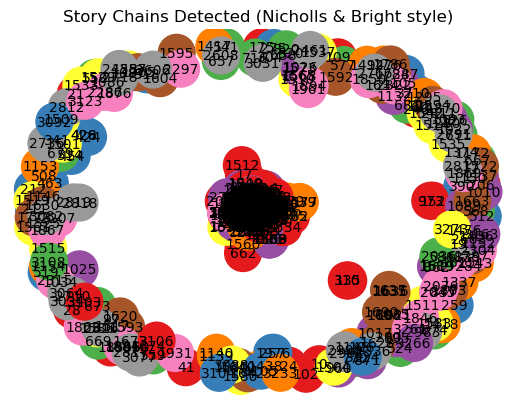

      article_id                                    cleaned_content  \
0              0  Link to Story\n\nIn October, Ethiopian Prime M...   
1              1  Eritrea acknowledged its troops are taking par...   
2              2  Rebels in Ethiopia's war-hit Tigray have carri...   
3              3  Ethiopia declared a six-month state of emergen...   
4              4  ruled in March that all voting would need to b...   
...          ...                                                ...   
3317        3317  JOHANNESBURG: The first formal peace talks aim...   
3318        3318  Today, U.S. Senator Chris Van Hollen led over ...   
3319        3319  Tigrayan rebels announced Monday that they are...   
3320        3320  Ethiopia’s military is warning civilians in th...   
3321        3321  Cafes and markets are bustling, roads are bein...   

      story_chain  
0               0  
1               1  
2               0  
3               0  
4               0  
...           ...  
3317   

In [63]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
# !pip install python-louvain
import community as community_louvain  # python-louvain
import matplotlib.pyplot as plt

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(article_df['cleaned_content'].astype(str).tolist(), convert_to_tensor=False)


similarity_matrix = cosine_similarity(embeddings)


threshold = 0.7
G = nx.Graph()


for idx, row in article_df.iterrows():
    G.add_node(idx, article_id=row['article_id'])

#  Add edges based on similarity threshold
for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        sim = similarity_matrix[i][j]
        if sim >= threshold:
            G.add_edge(i, j, weight=sim)


partition = community_louvain.best_partition(G)

article_df['story_chain'] = article_df.index.map(partition)


pos = nx.spring_layout(G, seed=42)
colors = [partition[n] for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.Set1, node_size=700)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, labels={i: str(article_df['article_id'][i]) for i in G.nodes()}, font_size=10)
plt.title("Story Chains Detected (Nicholls & Bright style)")
plt.axis('off')
plt.show()

print(article_df[['article_id', 'cleaned_content', 'story_chain']])


# Semantic Similarity Score 
Using Cosine Similarity by embedding articles and events batch by batch for better accuracy (sentence level embedding) (slower but finer)

The previous one encodes the whole text at one, even though it is fast, inaccurate in finding patterns, also possible in losing overall context

In [46]:
# With Cosine Similarity

from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer, util
from nltk.tokenize import sent_tokenize
import nltk
import torch
import pandas as pd

#nltk.download('punkt')

model = SentenceTransformer("BAAI/bge-base-en-v1.5")  # or 'bge-large-en-v1.5'

# article_df['cleaned_content']
# article_df['matching_events'] = list of event_ids within same time window
# events_df['event_id'], events_df['text']


# Event embedding index (for fast lookup)
events_df['title'] = events_df['title'].fillna('').astype(str)
events_id_to_vector = {
    row['event_id']: model.encode(row['title'], convert_to_tensor=True, batch_size=32, show_progress_bar=False)
    for _, row in events_df.iterrows()
}

# --- Function to embed and average article sentences
def embed_article_sentences(text):
    sentences = sent_tokenize(text)
    if not sentences:
        return torch.zeros(model.get_sentence_embedding_dimension())
    sentence_embeddings = model.encode(sentences, convert_to_tensor=True, batch_size=32, show_progress_bar=False)
    return torch.mean(sentence_embeddings, dim=0) # gets you a single embedding for the whole paragraph by finding the mean

# compare only against its matching_events
article_match_scores = []
article_match_ids = []

for idx, row in article_df.iterrows():
    article_vec = embed_article_sentences(row.title)

    matching_event_ids = row.get('matching_events', [])
    if not matching_event_ids:
        article_match_scores.append(None)
        article_match_ids.append(None)
        continue

    # Get event vectors for those in the matching time window
    event_vecs = [events_id_to_vector[eid] for eid in matching_event_ids if eid in events_id_to_vector]
    
    if not event_vecs:
        article_match_scores.append(None)
        article_match_ids.append(None)
        continue

    event_tensor = torch.stack(event_vecs) # create a 2D matrix for cosine similarity, it won't work on a list

    # Cosine similarity
    sim_scores = util.cos_sim(article_vec, event_tensor).squeeze(0)  # Shape: [num_events]
    
    scores_list = sim_scores.tolist()

    article_match_scores.append(scores_list)
    article_match_ids.append(matching_event_ids)

# Attach to DataFrame
article_df['match_score_Title'] = article_match_scores
article_df['event_similarity_id_Title'] = article_match_ids


In [ ]:
to_find

In [ ]:
# conda install -c conda-forge faiss-cpu
# Using Faiss - Index for Efficient Similarity Search
# the event Id with the maximum score is the one selected as sim text

import faiss
import numpy as np
import torch
import pandas as pd
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer, util
from nltk.tokenize import sent_tokenize
import nltk

# nltk.download('punkt')

# Load model
model = SentenceTransformer('BAAI/bge-base-en-v1.5')

events_df['title'] = events_df['title'].fillna('').astype(str)
event_embeddings = model.encode(events_df['title'].tolist(), convert_to_numpy=True, batch_size=32, show_progress_bar=True)

# Normalize for cosine similarity (FAISS requires this for inner product)
faiss.normalize_L2(event_embeddings)

# Build index
dim = event_embeddings.shape[1]
# index = faiss.IndexFlatIP(dim)
# index.add(event_embeddings)


# FAISS index to event_ids
faiss_id_to_event_id = dict(enumerate(events_df['event_id']))

def embed_article_sentences(text):
    sentences = sent_tokenize(text)
    if not sentences:
        return np.zeros((model.get_sentence_embedding_dimension(),), dtype=np.float32)
    sentence_embeddings = model.encode(sentences, convert_to_numpy=True, batch_size=32, show_progress_bar=False)
    return np.mean(sentence_embeddings, axis=0)

# === STEP 3: Matching each article ===
article_match_scores = []
article_match_ids = []
article_ids = []

for idx, row in article_df.iterrows():
    article_vec = embed_article_sentences(row.title)
    faiss.normalize_L2(article_vec.reshape(1, -1))  # Normalize for cosine

    matching_event_ids = row.get('matching_events', [])
    if not matching_event_ids:
        article_match_scores.append(None)
        article_match_ids.append(None)
        continue

    matching_faiss_indices = [i for i, eid in faiss_id_to_event_id.items() if eid in matching_event_ids]
    if not matching_faiss_indices:
        article_match_scores.append(None)
        article_match_ids.append(None)
        continue

    index = faiss.IndexFlatIP(dim) # Recreating Index for each event embeddings without being repetitive
    index.add(event_embeddings[matching_faiss_indices])  # Add only the matching events to the index
    
    # if the number of sim_indices is less than the k value it will have 0/None in it (nearest neighbours)
    # Query FAISS index for all events, get scores
    sim_scores, sim_indices = index.search(article_vec.reshape(1, -1), k=len(matching_faiss_indices))
    sim_scores = sim_scores[0]
    sim_indices = sim_indices[0]

    # Filter to matching_event_ids only
    filtered_scores = []
    filtered_event_ids = [] # sim-indices is faiss-index which is converted using event-faiss-lookup
    for score, idx_in_faiss in zip(sim_scores, sim_indices):
        eid = faiss_id_to_event_id.get(idx_in_faiss)
        if eid in matching_event_ids:
            filtered_scores.append(score)
            filtered_event_ids.append(eid)
            
    if not filtered_scores: # Just so filtered_scores wasn't empty
        article_ids.append(row['article_id'])
        article_match_scores.append(None)
        article_match_ids.append(None)
        continue

    max_idx = np.argmax(filtered_scores) # index with highest probability
    max_score = filtered_scores[max_idx]
    max_eid = filtered_event_ids[max_idx]


    article_ids.append(row['article_id'])
    article_match_scores.append(float(max_score))
    article_match_ids.append(max_eid)


score_dict = dict(zip(article_ids, article_match_scores))
article_df['match_score'] = article_df['article_id'].map(score_dict)


Batches: 100%|██████████| 79/79 [04:29<00:00,  3.42s/it] 


In [347]:
match_score_lookup = article_df.set_index('article_id')['match_score_Title']

for match in match_list:
    aid = match.get('article_id')
    match['match_score_Title'] = match_score_lookup.get(aid, None)

In [39]:
event_similarity_by_article_title_lookup = article_df.set_index('article_id')['event_similarity_id_Title']

for match in match_list:
    aid = match.get('article_id')
    match['event_similarity_id_Title'] = event_similarity_by_article_title_lookup.get(aid, None)

NameError: name 'match_list' is not defined

In [ ]:
import pandas as pd

# Assuming match_list is your list of dictionaries
match_df = pd.DataFrame(match_list)

# Export to CSV — no frills, just facts
match_df.to_csv('match_list.csv', index=False)


In [217]:

article_df.to_csv("matched_articles.csv", index=False)


In [ ]:
import joblib

# Bundle everything into a dictionary
data_bundle = {
    'article_df': article_df,
    'events_df': events_df,
    'events_entities_long': events_entities_long,
    'entities_long': entities_long,
    'all_entities': all_entities,
    'all_events_entities': all_events_entities,
    'entity_counter': entity_counter,
    'entity_events_counter': entity_events_counter,
    'raw_ethiopia_entities': raw_ethiopia_entities,
    'raw_events_entities': raw_events_entities,
    'mapped_articles_entities_dictionary': mapped_articles_entities_dictionary,
    'mapped_events_entities_dictionary': mapped_events_entities_dictionary,
    'normalized_articles_entities': normalized_articles_entities,
    'normalized_events_entities': normalized_events_entities,
    'match_list': match_list
    
}

# Save to disk
joblib.dump(data_bundle, 'session_backup.pkl')


['session_backup.pkl']

# Temporal Proximity Scores

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import math

# Convert to datetime if needed
article_df['Load_Date'] = pd.to_datetime(article_df['Load_Date'])
events_df['date_str'] = pd.to_datetime(events_df['date_str'])

# Params from the paper
alpha_h = 1.0  # for historical
alpha_p = 0.8  # for predictive
lambda_ = 0.8
max_past_days = 30
max_future_days = 10

# Convert events_df to a dict for fast lookup
event_date_lookup = dict(zip(events_df['event_id'], events_df['date_str']))

# Function to calculate temporal proximity 
# Distance from 0 is considered over negative or positive value
def compute_exp_temporal_score(pub_date, event_date):
    delta_days = (event_date - pub_date).days  # Positive if event after article (predictive)
    
    if delta_days > 0:
        # Predictive reporting
        decay = delta_days / max_future_days
        score = alpha_p * np.exp(-lambda_ * decay)
    else:
        # Historical reporting
        decay = abs(delta_days) / max_past_days
        score = alpha_h * np.exp(-lambda_ * decay)
    
    return round(score, 4)

def compute_log_temporal_score(pub_date, event_date):
    delta_days = abs((event_date - pub_date).days)

    if delta_days > 0:
        H = 10
    else:
        H = 30

    value = (delta_days + 1)/H
    inner = math.log(value)
    if inner <= 0.0:
        return 0.0
    
    score = -math.log(H * inner) / math.log(H)
    return round(score, 4)

# Apply to all article-event pairs
def compute_temporal_scores(row):
    pub_date = row['Load_Date']
    matching_events = row.get('matching_events', [])

    exp_scores = {}
    log_scores = {}

    for eid in matching_events:
        event_date = event_date_lookup.get(eid)

        if pd.notna(event_date):
            exp_score = compute_temporal_score(pub_date, event_date)
            exp_scores[eid] = exp_score

            log_score = compute_log_temporal_score(pub_date, event_date)
            log_scores[eid] = log_score

    return {'exp': exp_scores, 'log': log_scores}

# Add temporal proximity scores to article_df
article_df['temporal_scores'] = article_df.apply(compute_temporal_scores, axis=1)


In [358]:
temporal_scores_map = article_df['temporal_scores'].to_dict()

for match in match_list:
    aid = match['article_id']
    eid = match['event_id']

    ts_for_article = temporal_scores_map.get(aid, {})
    exp_scores = ts_for_article.get('exp', {})
    log_scores = ts_for_article.get('log', {})

    match['temporal_exp_score'] = exp_scores.get(eid, 0.0)
    match['temporal_log_score'] = log_scores.get(eid, 0.0)

In [360]:
from collections import defaultdict

exp_scores_by_article = defaultdict(list)
log_scores_by_article = defaultdict(list)

for match in match_list:
    aid = match['article_id']
    exp_scores_by_article[aid].append(match.get('temporal_exp_score', 0.0))
    log_scores_by_article[aid].append(match.get('temporal_log_score', 0.0))


article_df['temporal_exp_score'] = article_df['article_id'].map(exp_scores_by_article)
article_df['temporal_log_score'] = article_df['article_id'].map(log_scores_by_article)


In [ ]:
match_score_Title = article_df['match_score_Title'].to_dict()

for match in match_list:
    aid = match['article_id']
    match['match_score_Title'] = match_score_Title.get(aid, {})

In [128]:
article_df.columns

Index(['doc_id', 'doc_id', 'doc_id', 'doc_id', 'doc_id', 'title', 'author',
       'source', 'content', 'topic', 'url', 'keywords', 'query',
       'cleaned_content', 'entities', 'article_id', 'entities_Group',
       'labels_Group', 'Key_Phrases', 'Actions', 'Load_Date', 'Language',
       'Person', 'matching_events', 'character_count', 'word_count',
       'processed_text', 'processed_tokens_split', 'num_tokens',
       'actor_entities_x', 'geo_entities_x', 'story_chain',
       'match_score_faiss', 'temporal_scores', 'temporal_exp_score',
       'temporal_log_score', 'match_score_Title', 'event_similarity_id_Title',
       'match_label_x', 'match_label_y', 'match_label', 'actor_entities_y',
       'geo_entities_y'],
      dtype='object')

# Combined Score and Similarity Aggregate


In [154]:
import itertools


def normalize_score(score, min_val, max_val):
    return (score - min_val) / (max_val - min_val) if max_val > min_val else 0

def combined_score(row, weights, min_vals, max_vals):
    entity_ = normalize_score(row.get('entity_similarity', 0), min_vals['entity_similarity'], max_vals['entity_similarity'])
    temporal_ = normalize_score(row.get('temporal_exp_score', 0), min_vals['temporal_exp_score'], max_vals['temporal_exp_score'])

    sim_scores = row.get('match_score_Title', [])
    
    combined_scores = []

    for sim_score in sim_scores:
        semantic_ = normalize_score(sim_score, min_vals['text_similarity'], max_vals['text_similarity'])
        combined = (
            weights['semantic'] * semantic_ + 
            weights['entity'] * entity_ +
            weights['temporal'] * temporal_
        )
        combined_scores.append(combined)
    if combined_scores:
        max_score = max(combined_scores)
        max_index = combined_scores.index(max_score)
        return pd.Series([max_score, max_index])
    else:
        return pd.Series([0, -1])


def classify_match(score, threshold=0.3):
    return "Valid" if score >= threshold else "Invalid"


weights = {
    'semantic': 0.5,
    'entity': 0.4,
    'temporal': 0.2
}

all_sim_scores = list(itertools.chain.from_iterable(article_df['match_score_Title'].dropna()))
min_sim = min(all_sim_scores) if all_sim_scores else 0
max_sim = max(all_sim_scores) if all_sim_scores else 1  # avoid div by zero



min_vals = {
    'text_similarity': min_sim,
    'entity_similarity': article_df['entity_similarity'].min(),
    'temporal_exp_score': article_df['temporal_exp_score'].min()
}

max_vals = {
    'text_similarity': max_sim,
    'entity_similarity': article_df['entity_similarity'].max(),
    'temporal_exp_score': article_df['temporal_exp_score'].max()
}

article_df[['final_scores', 'max_score_index']] = article_df.progress_apply(
    lambda row: combined_score(row, weights, min_vals, max_vals), axis=1
)
article_df['match_Labels'] = article_df['final_scores'].progress_apply(classify_match)


100%|██████████| 3322/3322 [00:00<00:00, 547914.98it/s]


In [172]:
article_df['entity_similarity']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3317    0.0
3318    0.0
3319    0.0
3320    0.0
3321    NaN
Name: entity_similarity, Length: 3322, dtype: float64

In [367]:
# Step 1: Collapse match_list to one label per article_id, favoring "Valid"
match_df = pd.DataFrame(match_list)

article_labels = (
    match_df.groupby('article_id')['match_label']
    .apply(lambda labels: 'Valid' if 'Valid' in labels.values else 'Invalid')
    .reset_index(name='match_label')  # <-- THE FIX
)

# Step 2: Merge into article_df
article_df = article_df.merge(article_labels, on='article_id', how='left')



In [155]:
article_df['match_label'] = article_df['match_label'].fillna('Invalid')

In [ ]:
# Train Logistic Regression Model for Weights

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = match_list[['text_simillarity', 'entity_similarity', 'temporal_exp_score']]
y = match


In [156]:
article_df['match_label'].value_counts()


match_label
Valid      2740
Invalid     582
Name: count, dtype: int64

In [157]:
unique_article_ids = set(match['article_id'] for match in match_list)
print(f"Unique article_ids in match_list: {len(unique_article_ids)}")


Unique article_ids in match_list: 2746


In [374]:
# Step 1: Convert match_list to DataFrame if it isn't already

match_df = pd.DataFrame(match_list)

# Step 2: Merge match_df with events_df on 'event_id'
match_df = match_df.merge(events_df[['event_id', 'title']], on='event_id', how='left')
match_list = match_df.to_dict(orient='records')


In [160]:
article_df['max_score_index']

0        80.0
1        15.0
2        89.0
3        26.0
4         4.0
        ...  
3317    184.0
3318     24.0
3319     23.0
3320     26.0
3321     -1.0
Name: max_score_index, Length: 3322, dtype: float64

In [161]:
article_df['match_score_Title']

0       [0.4584193825721741, 0.5096662640571594, 0.406...
1       [0.6830078363418579, 0.6830078363418579, 0.778...
2       [0.6917966604232788, 0.6439464688301086, 0.629...
3       [0.37836530804634094, 0.4262385070323944, 0.41...
4       [0.3413371443748474, 0.5472155809402466, 0.373...
                              ...                        
3317    [0.5201985836029053, 0.5584793090820312, 0.515...
3318    [0.5058121085166931, 0.5040508508682251, 0.572...
3319    [0.624632716178894, 0.6089861392974854, 0.4885...
3320    [0.36514467000961304, 0.4888526201248169, 0.63...
3321                                                   []
Name: match_score_Title, Length: 3322, dtype: object

In [165]:
def get_event_id_from_max_index(row):
    idx = int(row['max_score_index'])
    events_ids = row['event_similarity_id_Title']
    if events_ids and isinstance(events_ids, list) and  0 <= idx < len(events_ids):
        return events_ids[idx]
    else:
        return None
    
article_df['Top_event_id'] = article_df.apply(get_event_id_from_max_index, axis =1 )

In [169]:
# Create the mapping dictionary once
event_id_to_title = dict(zip(events_df['event_id'], events_df['title']))

# Define a function that maps only if match_label is Valid
def map_title_if_valid(row):
    if row['match_label'] == 'Valid':
        return event_id_to_title.get(row['Top_event_id'], None)
    else:
        return None

# Apply this function row-wise
article_df['Top_event_title'] = article_df.apply(map_title_if_valid, axis=1)


In [170]:
article_df['Top_event_title'].notna().sum()

2740

In [171]:
article_df.to_csv('matching_articles04.csv', index=False)

In [89]:
# # Count the distribution per source 
# # !pip install seaborn
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))
# ax = sns.countplot(x='Entities', data=df, order=df['bias_labels'].value_counts().index)
# plt.title('Distribution of Articles per Bias Labels')
# plt.xlabel('Bias Labels')
# plt.ylabel('Count')

# total = len(article_df)

# for p in ax.patches:
#     count = p.get_height()
#     percentage = 100 * count/total
#     x = p.get_x() + p.get_width()/2 # to locate the value over the plot
#     y = p.get_height()
#     ax.text(x, y+total*0.01, f'{percentage: .1f}%', ha='center')
# sns.set(style="whitegrid")
# plt.show()


In [78]:
## Oversampling using SMOTE

# from imblearn.over_sampling import SMOTENC
# X = df.drop(columns = ['bias_labels'])
# y = df['bias_labels']


# categorical_features = [X.columns.get_loc(col) for col in categorical_columns if col != 'bias_labels']

# sm = SMOTENC(categorical_features=categorical_features,random_state=42)
# X_res, y_res = sm.fit_resample(X, y)

# df_smote = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='bias_labels')], axis=1)


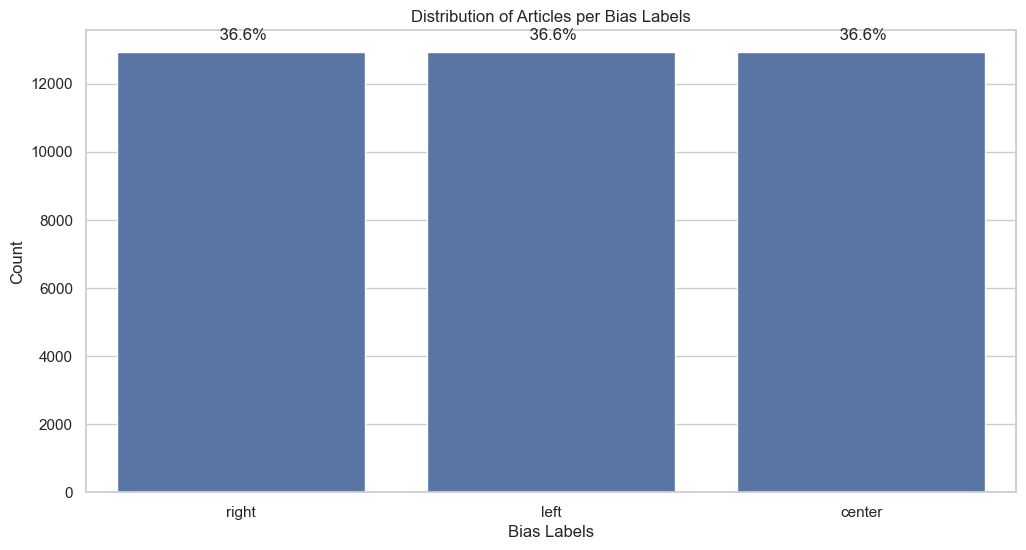

In [ ]:
# Count the distribution per source 
# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='bias_labels', data=df_smote, order=df['bias_labels'].value_counts().index)
plt.title('Distribution of Articles per Bias Labels')
plt.xlabel('Bias Labels')
plt.ylabel('Count')

total = len(df)

for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count/total
    x = p.get_x() + p.get_width()/2 # to locate the value over the plot
    y = p.get_height()
    ax.text(x, y+total*0.01, f'{percentage: .1f}%', ha='center')
sns.set(style="whitegrid")
plt.show()


In [14]:
!pip install wordcloud

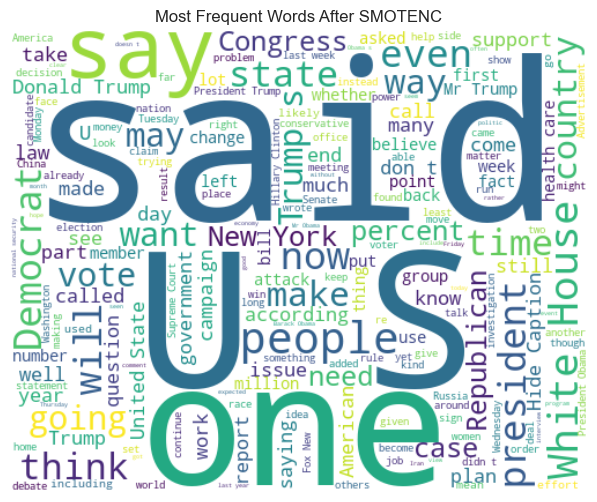

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df_smote['content'].astype(str))
wordcloud = WordCloud(width=500, height=400, background_color='white').generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words After SMOTENC')
plt.show()

In [39]:
# !python -m spacy download en_core_web_sm


In [38]:
# # Lemmatization is done for most of the ML models, so it is not done here
# import nltk
# #nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

# lemmatizer = WordNetLemmatizer()

# def lemma(text):
#     tokens = word_tokenize(text)
#     lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
#     return " ".join(lemmatized_tokens)

# df_smote['lemmatized_content'] = df_smote['content'].progress_apply(lemma)

In [37]:
# df_smote['lemmatized_content'].head(5)

In [81]:
# Concentration Ratio
import itertools

df_left = df_smote[df_smote['bias_labels'] == 'left']
df_right = df_smote[df_smote['bias_labels'] == 'right']
df_center = df_smote[df_smote['bias_labels'] == 'center']

df_left_s1 = df_left['processed_text'].tolist()
df_right_s1 = df_right['processed_text'].tolist()
df_center_s1 = df_center['processed_text'].tolist()



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def concentration_ratio(lsts = []):
    combined_lists = []
    for l in lsts:
        combined_lists.append(' '.join(l)) # join the tokens in each list one by one

    tfidf_vec = TfidfVectorizer(max_features=8000,
                        encoding='utf-8',
                        token_pattern = r'\b\w+\b',
                         )
    # the fit_transform will arrange the tokens columnswise for all the lists 
    # appended which makes it easier to find the sum of the total count of tokens 
    # in each list. Shape(3, number of tokens)

    combined_sparse_matrix = tfidf_vec.fit_transform(combined_lists) 
    fitted_df = pd.DataFrame(combined_sparse_matrix.toarray(), columns = tfidf_vec.get_feature_names_out())
    col_sums = fitted_df.sum(axis=0) # shape(3, 8000)
    #Normalize
    df_normalized = fitted_df.div(col_sums, axis=1) #shape (3, 8000)

    df_normalized.columns = [col + '_norm' for col in tfidf_vec.get_feature_names_out()]
    # rowwise : 0 - left, 1 - right, 2 - center (entire 0, 1, 2 row)
    df_left_right_ratio = df_normalized.iloc[0]/df_normalized.iloc[1].replace(0, 1e-9)
    df_left_center_ratio = df_normalized.iloc[0]/df_normalized.iloc[2].replace(0, 1e-9)
    df_right_center_ratio = df_normalized.iloc[1]/df_normalized.iloc[2].replace(0, 1e-9)
   
  # Put ratios into DataFrame with tokens as index # shape (8000, 3)
    df_ratio = pd.DataFrame({                           
        'left_center_ratio': df_left_center_ratio,
        'right_center_ratio': df_right_center_ratio,
        'left_right_ratio': df_left_right_ratio
    })

    # Transpose fitted_df and df_normalized so tokens are rows
    fitted_df = fitted_df.T
    # New Shape(8000, 3)
    fitted_df.columns = ['left_tfidf', 'center_tfidf', 'right_tfidf']

    df_normalized = df_normalized.T
    # new Shape(8000, 3)
    df_normalized.columns = ['left_norm', 'center_norm', 'right_norm']
    print(df_normalized.head(5))

    # Set tokens as index for fitted_df and df_normalized for consistent concat
    fitted_df.index = tfidf_vec.get_feature_names_out()
    df_normalized.index = tfidf_vec.get_feature_names_out()
    df_ratio.index = tfidf_vec.get_feature_names_out()

    # Concatenate horizontally (axis=1) — tokens as rows
    df_combined = pd.concat([df_ratio, fitted_df, df_normalized], axis=1)

    # Reset index and rename 'index' column to 'token'
    df_combined.reset_index(inplace=True)
    df_combined.rename(columns={'index': 'token'}, inplace=True)


    # Return all useful dataframes
    return df_combined
    
results = concentration_ratio(lsts=[df_left_s1, df_center_s1, df_right_s1])

          left_norm  center_norm  right_norm
0_norm     0.196256     0.481517    0.322227
00_norm    0.585793     0.285965    0.128242
000_norm   0.289549     0.372744    0.337707
01_norm    0.889320     0.078818    0.031862
02_norm    0.894621     0.074987    0.030392


In [51]:
print(results)

           token  left_center_ratio  right_center_ratio  left_right_ratio  \
0              0           0.609061            1.494339          0.407579   
1             00           4.567889            2.229897          2.048476   
2            000           0.857399            1.103752          0.776803   
3             01          27.911529            2.473725         11.283199   
4             02          29.436134            2.467323         11.930395   
...          ...                ...                 ...               ...   
7995        zero           0.942920            0.957411          0.984864   
7996   zimmerman           0.786853            0.410962          1.914664   
7997        zone           1.186853            1.245910          0.952599   
7998       zones           1.063826            1.743829          0.610052   
7999  zuckerberg           1.337049            1.506039          0.887791   

      left_tfidf  center_tfidf  right_tfidf  left_norm  center_norm  \
0   

In [52]:
# Visualize the Left-Right Skewness in Plot
left_right_ratio = results.sort_values('left_right_ratio', ascending=False)
right_left_ratio = results.sort_values('left_right_ratio', ascending=True)
# Ratio so 1/1 is the balanced value not 0
neutral_ratio = results[(results['left_right_ratio'] > 0.95) & (results['left_right_ratio'] < 1.05)]

In [53]:
left_center_ratio = results.sort_values('left_center_ratio', ascending=False)
center_left_ratio = results.sort_values('left_center_ratio', ascending=True)

right_center_ratio = results.sort_values('right_center_ratio', ascending=False)
center_right_ratio = results.sort_values('right_center_ratio', ascending=True)



In [56]:
top_left_right_ratio = left_right_ratio[['token', 'left_right_ratio']].head(10)
top_right_left_ratio = right_left_ratio[['token', 'left_right_ratio']].head(10)
top_left_center_ratio = left_center_ratio[['token', 'left_center_ratio']].head(10)
top_center_left_ratio = center_left_ratio[['token', 'left_center_ratio']].head(10)
top_right_center_ratio = right_center_ratio[['token', 'right_center_ratio']].head(10)
top_center_right_ratio = center_right_ratio[['token', 'right_center_ratio']].head(10)

/var/folders/1_/1tlll79x3z32x6h88brvgx7r0000gn/T/ipykernel_18774/2244697379.py:7: UserWarning: Glyph 8811 (\N{MUCH GREATER-THAN}) missing from font(s) Arial.
  plt.tight_layout()


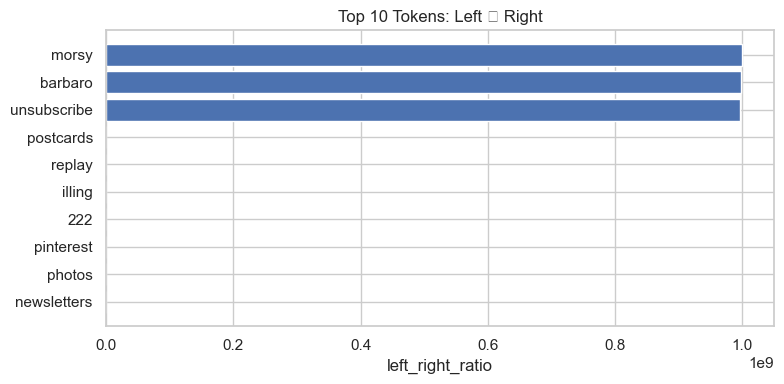

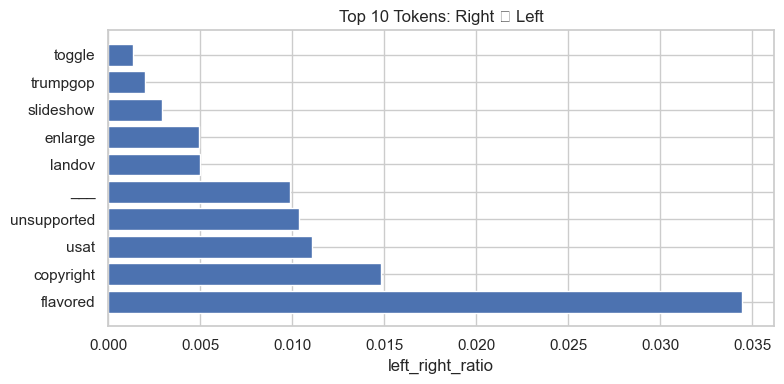

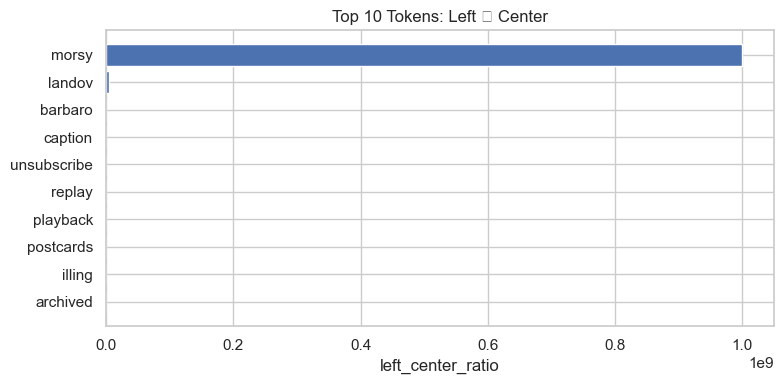

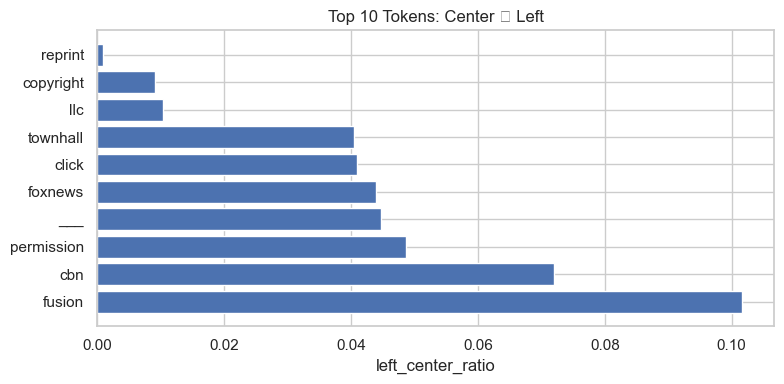

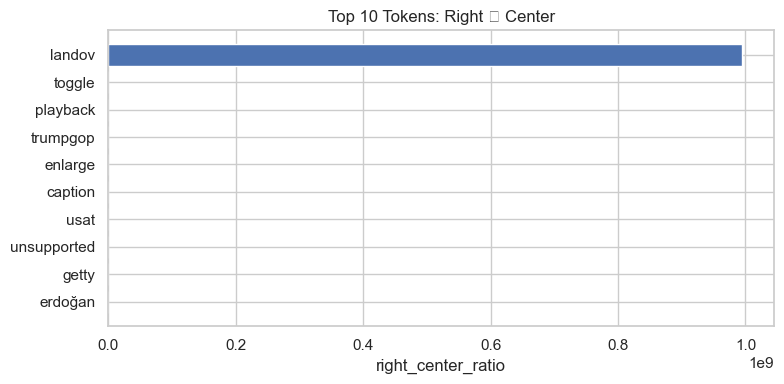

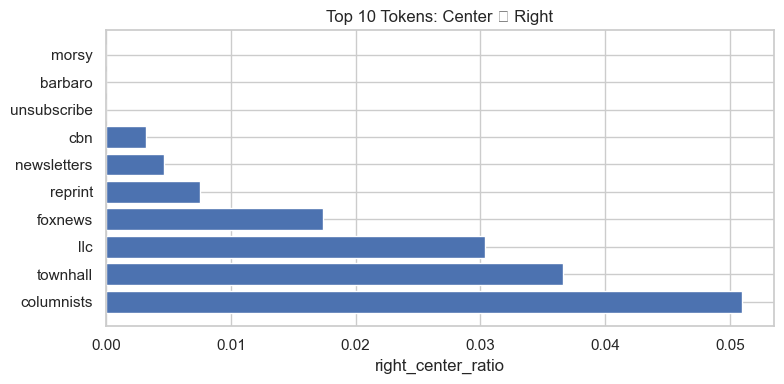

In [60]:
def plot_top(df, ratio_col, title):
    plt.figure(figsize=(8, 4))
    plt.barh(df['token'], df[ratio_col]) # x and values
    plt.gca().invert_yaxis()
    plt.xlabel(ratio_col)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top(top_left_right_ratio, 'left_right_ratio', "Top 10 Tokens: Left ≫ Right")
plot_top(top_right_left_ratio, 'left_right_ratio', "Top 10 Tokens: Right ≫ Left")
plot_top(top_left_center_ratio, 'left_center_ratio', "Top 10 Tokens: Left ≫ Center")
plot_top(top_center_left_ratio, 'left_center_ratio', "Top 10 Tokens: Center ≫ Left")
plot_top(top_right_center_ratio, 'right_center_ratio', "Top 10 Tokens: Right ≫ Center")
plot_top(top_center_right_ratio, 'right_center_ratio', "Top 10 Tokens: Center ≫ Right")

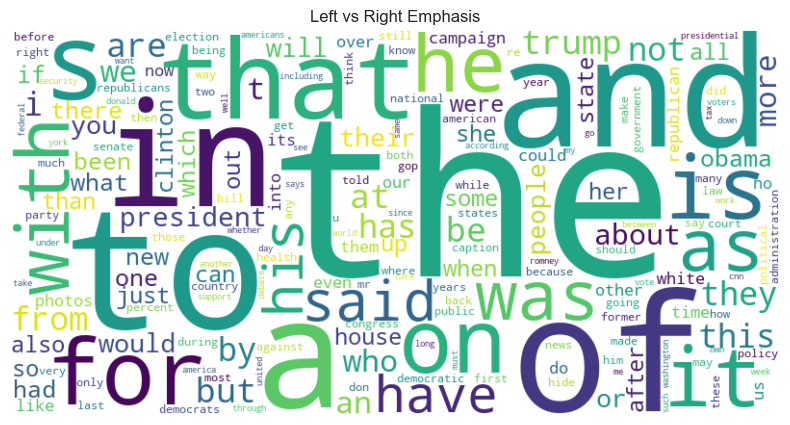

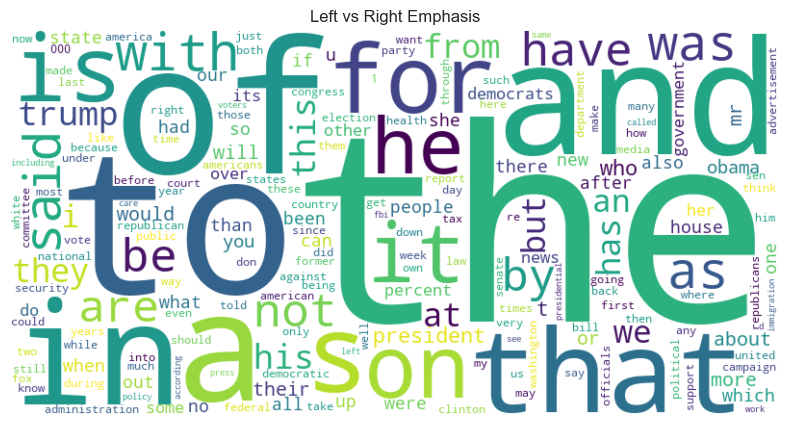

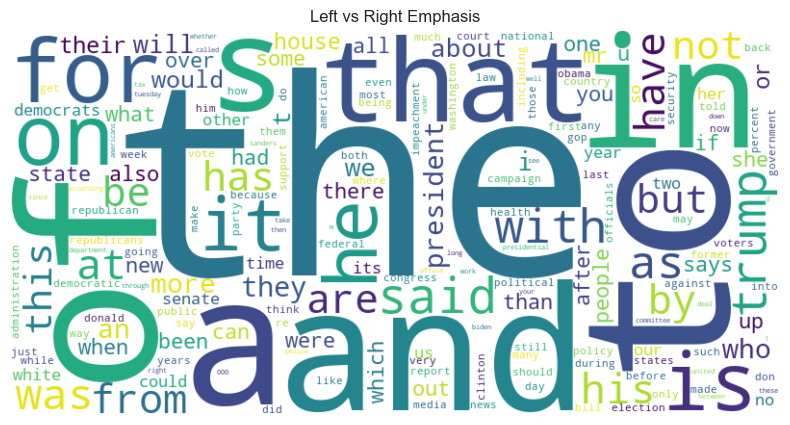

In [ ]:
# WordCloud using Concentration Ratio to show Bias and Visualise dominant words on each label
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(data, class_col, title):
    freqs = data.set_index('token')[class_col].to_dict()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()


plot_wordcloud(results, 'left_tfidf', "Left vs Right Emphasis")
plot_wordcloud(results, 'right_tfidf', "Left vs Right Emphasis")
plot_wordcloud(results, 'center_tfidf', "Left vs Right Emphasis")


In [69]:
# Sentiment AAnalysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
#results['sentiment'] = results[]


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amalkurian/nltk_data...


In [82]:
df_smote['sentiment'] = df_smote['content'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])
df_smote['sentiment']

  0%|          | 0/38766 [00:00<?, ?it/s]

100%|██████████| 38766/38766 [16:52<00:00, 38.28it/s]  


0        0.4084
1       -0.7579
2       -0.0258
3       -0.7579
4        0.8020
          ...  
38761    0.9990
38762   -0.9970
38763   -0.9747
38764   -0.7805
38765   -0.9984
Name: sentiment, Length: 38766, dtype: float64

In [83]:
def label_sentiment(score):
    if score > 0.05:
        return f'Positive'
    elif score < -0.05:
        return f'Negative'
    else:
        return f'Neutral'


df_smote['label_sentiment'] = df_smote['sentiment'].progress_apply(label_sentiment)

  0%|          | 0/38766 [00:00<?, ?it/s]

100%|██████████| 38766/38766 [00:00<00:00, 72190.63it/s]


In [84]:
df_smote['bias_labels'].value_counts()

bias_labels
right     12922
left      12922
center    12922
Name: count, dtype: int64

/var/folders/1_/1tlll79x3z32x6h88brvgx7r0000gn/T/ipykernel_18774/3400752379.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_smote, x='bias_labels', palette='Set2')


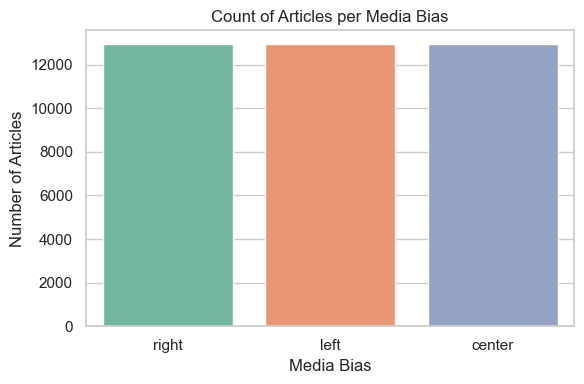

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df_smote, x='bias_labels', palette='Set2')

plt.title('Count of Articles per Media Bias')
plt.xlabel('Media Bias')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()
